# Choosing a location for a oil well

The goal of the project is to predict the profit and risk of oil extraction in three regions, each containing 10,000 oil fields. The budget for well development in each region is 10 billion rubles. It is necessary to select 200 wells. At the current prices, one barrel of crude oil brings a revenue of 450 rubles. Characteristics for each well in the region are known (represented as synthetic data f0, f1, f2).

The outcome of the project is a model for determining the region where extraction will yield the highest profit. Profit and risks were analyzed using the Bootstrap technique.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
import random
import scipy.stats as st
from sklearn.metrics import mean_squared_error, r2_score
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy.random import RandomState

In [2]:
warnings.filterwarnings('ignore')
sns.set()
sns.set_style("whitegrid")

Download dataset

In [3]:
d0 = pd.read_csv('geo_data_0.csv')
d0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
d0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
d0['id'] = d0['id'].str.lower()
d0.duplicated().sum()

0

In [6]:
d1 = pd.read_csv('geo_data_1.csv')
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
d1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
d1['id'] = d1['id'].str.lower()
d1.duplicated().sum()

0

In [9]:
d2 = pd.read_csv('geo_data_2.csv')
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
d2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [11]:
d2['id'] = d2['id'].str.lower()
d2.duplicated().sum()

0

In [12]:
d_set = [d0,d1,d2]

Look at destributions of differents features in the regions

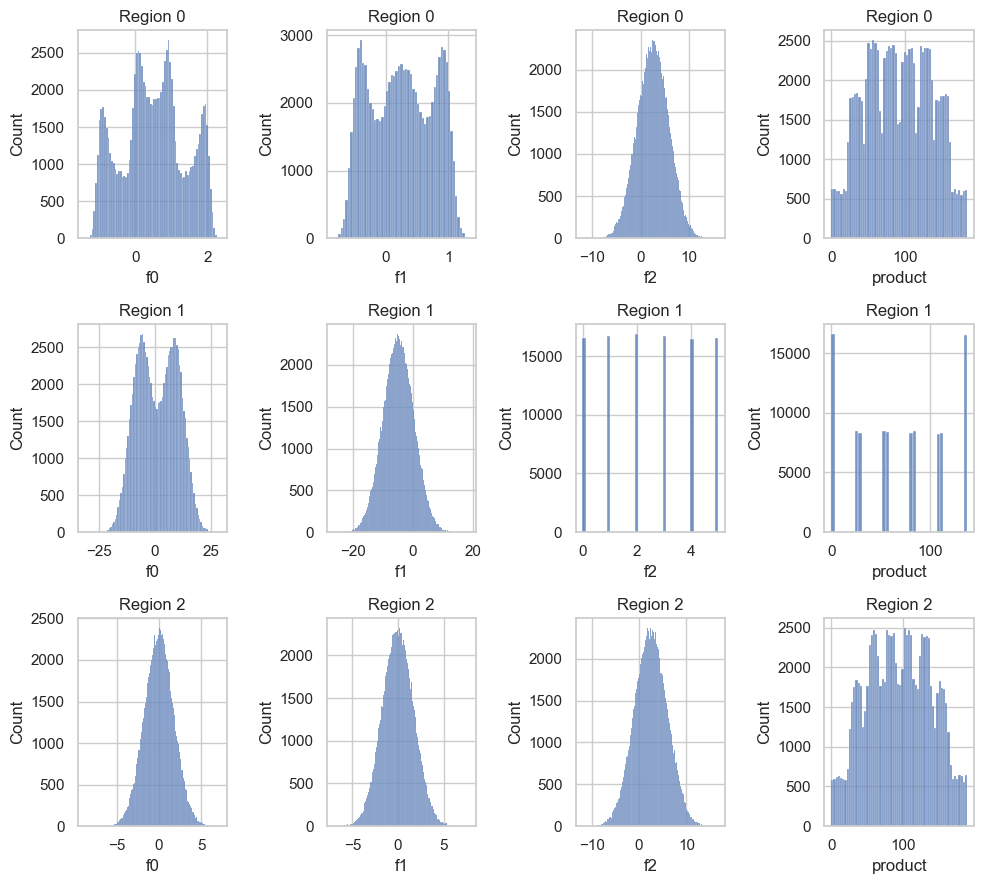

In [13]:
c = 0
fig, ax = plt.subplots(3, 4, figsize=(10, 9))
for s in d_set:
    for i in range(4):
        ax[c, i].set_title(f'Region {c}')
        sns.histplot(s.iloc[:,1+i], ax=ax[c,i])
    c += 1
plt.tight_layout()

**Conclusions: The dataset verification revealed that the synthetic data is well-prepared without any missing values or duplicates. The behavior of features differs significantly across different regions, especially in the second region where the distribution is discrete**

## Model training

Let's split the data into features and target for training and validation. But first we encode the 'id' column

In [14]:
features_valid, features_train, target_valid, target_train = [],[],[],[]

In [15]:
for i in range(len(d_set)):
    f = d_set[i].drop(['product','id'], axis=1)
    t = d_set[i]['product']
    f_train, f_valid, t_train, t_valid = train_test_split(f,
                                                          t,
                                                          test_size=.25,
                                                          random_state=123,
                                                         )
    features_valid.append(f_valid)
    features_train.append(f_train)
    target_valid.append(t_valid)
    target_train.append(t_train)

Let's check features correlation

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


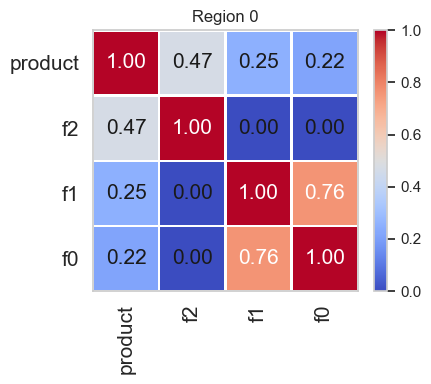

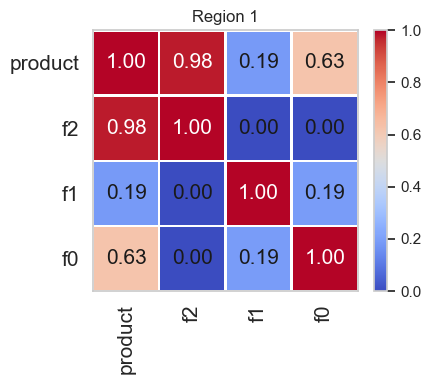

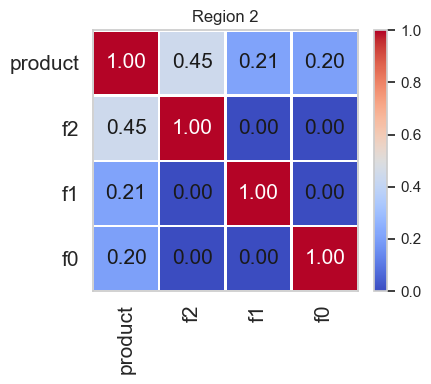

In [16]:
for i in range(3):
    phik_overview = pd.concat([features_train[i],target_train[i]],axis=1).phik_matrix()
    plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation $\phi_K$", 
                        color_map="coolwarm",
                        fontsize_factor=1.5, 
                        figsize=(4.5, 4))
    plt.title(f'Region {i}')
    plt.tight_layout()

The features do not correlate with each other, except for region 0, in which there is a correlation between f0 and f1

In [17]:
for s in features_train:
    print(s.shape)
for s in features_valid:
    print(s.shape)
for s in target_train:
    print(s.shape)
for s in target_valid:
    print(s.shape)

(75000, 3)
(75000, 3)
(75000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(75000,)
(75000,)
(75000,)
(25000,)
(25000,)
(25000,)


Let's train a linear regression model for the regions, calculate the average value of the number of barrels in the well and RMSE

In [18]:
model = LinearRegression()
target_predict = []
for i in range(3):
    model.fit(features_train[i],target_train[i])
    target_predict.append(model.predict(features_valid[i]))

In [19]:
i = 0
print('Average amount, thousand barrels')
for s in target_predict:
    print(f"Region {i}")
    print(round(s.mean()))
    i += 1

Average amount, thousand barrels
Region 0
93
Region 1
69
Region 2
95


In [20]:
print('RSME')
for i in range(3):
    print(f"Region {i}")
    mse = mean_squared_error(target_valid[i],target_predict[i])
    print(round(mse**.5))

RSME
Region 0
38
Region 1
1
Region 2
40


In [33]:
print('Coefficient of determination')
for i in range(3):
    print(f"Region {i}")
    r2 = r2_score(target_valid[i],target_predict[i])
    print(round(r2,2))

Coefficient of determination
Region 0
0.28
Region 1
1.0
Region 2
0.19


**Conclusion: Regions 0 and 2 showed similar results: the average is about 93-95, the RMSE is ~40 and even the parameters of the model. Region 1 showed a significantly worse result - 69 thousand bar., but its model is much more accurately predicted.** 

## Preparation for income calculation

Let's calculate how much each well should yield to break even.

The budget for well development in the region is 10 billion rubles, and we need to select 200 wells. At the current prices, one barrel of raw material brings in a revenue of 450 rubles. The revenue per unit of product is 450,000 rubles, as the volume is given in thousands of barrels.

Therefore, the average development cost is:

In [22]:
budget = 10*10**9
count_oilwell = 200

In [23]:
needed_value = budget / count_oilwell
print(f'Average cost of well development - {needed_value / 10**6} mill.r.')

Average cost of well development - 50.0 mill.r.


In order for the well to pay off, it must have the following amount of oil

In [24]:
income_per_barrel = 450
min_value = round(needed_value / income_per_barrel / 10 **3)
print(f'Required oil reserve in the well, thousand barrels - {min_value}')

Required oil reserve in the well, thousand barrels - 111


Note that the average oil reserve is significantly lower in a well in any region. Therefore, we will select only the best 200 wells

## Calculation of profit and risks

Convert the list of predicted values into a Series

In [25]:
target_predicted = []
for i in range(3):
    target_predicted.append(pd.Series(target_predict[i], index=target_valid[i].index))

Find the total amount of oil in the top 200 wells and the income from them, as well as the average values

In [36]:
for i in range(3):
    l = target_predicted[i].sort_values(ascending=False)[:200]
    print(f'Region {i}')
    print(f'Total oil reserve, K.bars - {round(l.sum())}')
    print(f'Total revenue, B.r. - {round(l.sum()  * income_per_barrel / 10**6 - 10,2)}')
    print(f'Average oil reserve, K.bars {round(l.mean())}')
    print(f'Average income, MM.r. {round(l.mean() * income_per_barrel / 10**3 - 50)}')
    print('- - - - - -')

Region 0
Total oil reserve, K.bars - 31035
Total revenue, B.r. - 3.97
Average oil reserve, K.bars 155
Average income, MM.r. 20
- - - - - -
Region 1
Total oil reserve, K.bars - 27756
Total revenue, B.r. - 2.49
Average oil reserve, K.bars 139
Average income, MM.r. 12
- - - - - -
Region 2
Total oil reserve, K.bars - 29943
Total revenue, B.r. - 3.47
Average oil reserve, K.bars 150
Average income, MM.r. 17
- - - - - -


In [38]:
target_predicted_98 = []
for i in range(3):
    treshold = target_predicted[i].quantile(q=0.98)
    target_predicted_98.append(target_predicted[i].loc[lambda x: x < treshold])

In [46]:
def profit_200(target, probabilities,revenue_oilwell=450*10**3,budget=10**10,count=200):
    """
    The function returns the income of the top 200 wells
    """
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return revenue_oilwell * selected.sum() - budget

In [39]:
state = np.random.RandomState(123)

In [44]:
def bootstrap_profit(target,predictions):
    """
    Returns average income, 95% confidence interval and probability of loss
    """
    income = []
    target = target[predictions.index] 
    for i in range(2000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        income.append(profit_200(target_sample,predictions_sample)) 
    mean_income = round(sum(income) / len(income), 2)    
    lower = round(np.percentile(income, 2.5), 2)
    higher = round(np.percentile(income, 97.5), 2)
    risk = round(st.percentileofscore(income, 0), 2)

    return (mean_income, (lower, higher),  risk)

*Calculate the potential income for each region*

In [47]:
c = 0
for target, prediction in zip(target_valid, target_predicted):
    mean_income, interval,  risk = bootstrap_profit(target,prediction)
    print(f'Region {c}')
    print(f'Average revenue - {round(mean_income / 10**9,3)}')
    print(f'Confidence interval - from {round(interval[0] / 10**9,3)} to {round(interval[1] / 10**9,3)}')
    print(f'Probability of loss - {risk}')
    c += 1

Region 0
Average revenue - 0.51
Confidence interval - from -0.029 to 0.999
Probability of loss - 3.0
Region 1
Average revenue - 0.521
Confidence interval - from 0.097 to 0.957
Probability of loss - 0.6
Region 2
Average revenue - 0.366
Confidence interval - from -0.182 to 0.915
Probability of loss - 10.2


**Conclusion: Bootstrap analysis showed that the most reliable region is Region 1. The average profit of the region is 0.5 billion rubles with a low risk of losing no more than 1%. The 95% confidence interval is between 0.099 and 0.956 billion rubles, indicating the reliability of the region. The riskiest region is Region 2, with a risk of losing around 10% and a potential profit of 0.3 billion rubles.**